In [204]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [115]:
# Getting the average batting% after 10 games
import os
import pandas as pd

# Folder with CSVs
folder = "test_data/batting_data"

# Collect batting data
all_data = []

# Load and sort CSV files by date from filename
csv_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".csv")],
    key=lambda x: pd.to_datetime(x.replace(".csv", ""))
)

# Read and append each CSV
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    all_data.append(df)

# Combine all into one DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Group by team abbreviation
tenth_averages = []

for team, group in combined_df.groupby("Team Abbreviation"):
    group = group.sort_values("Date")
    if len(group) >= 20:
        tenth_entry = group.iloc[19]  # 10th row (index 9)
        tenth_averages.append({
            "Team": tenth_entry["Team"],
            "Team Abbreviation": team,
            "20th Date": tenth_entry["Date"],
            "20th Batting Average": tenth_entry["Batting Average"]
        })

# Result as DataFrame
batting_df = pd.DataFrame(tenth_averages)

# Display
print(batting_df)

            Team Team Abbreviation   20th Date  20th Batting Average
0        Arizona               ARI  2025-04-15              0.255814
1        Atlanta               ATL  2025-04-15              0.224953
2      Baltimore               BAL  2025-04-15              0.237323
3         Boston               BOS  2025-04-15              0.247588
4       Chi Cubs               CHC  2025-04-15              0.257871
5        Chi Sox               CHW  2025-04-15              0.200846
6     Cincinnati               CIN  2025-04-15              0.199605
7      Cleveland               CLE  2025-04-15              0.221519
8       Colorado               COL  2025-04-15              0.218868
9        Detroit               DET  2025-04-15              0.249077
10       Houston               HOU  2025-04-15              0.218631
11   Kansas City               KCR  2025-04-15              0.212341
12     LA Angels               LAA  2025-04-15              0.236893
13    LA Dodgers               LAD

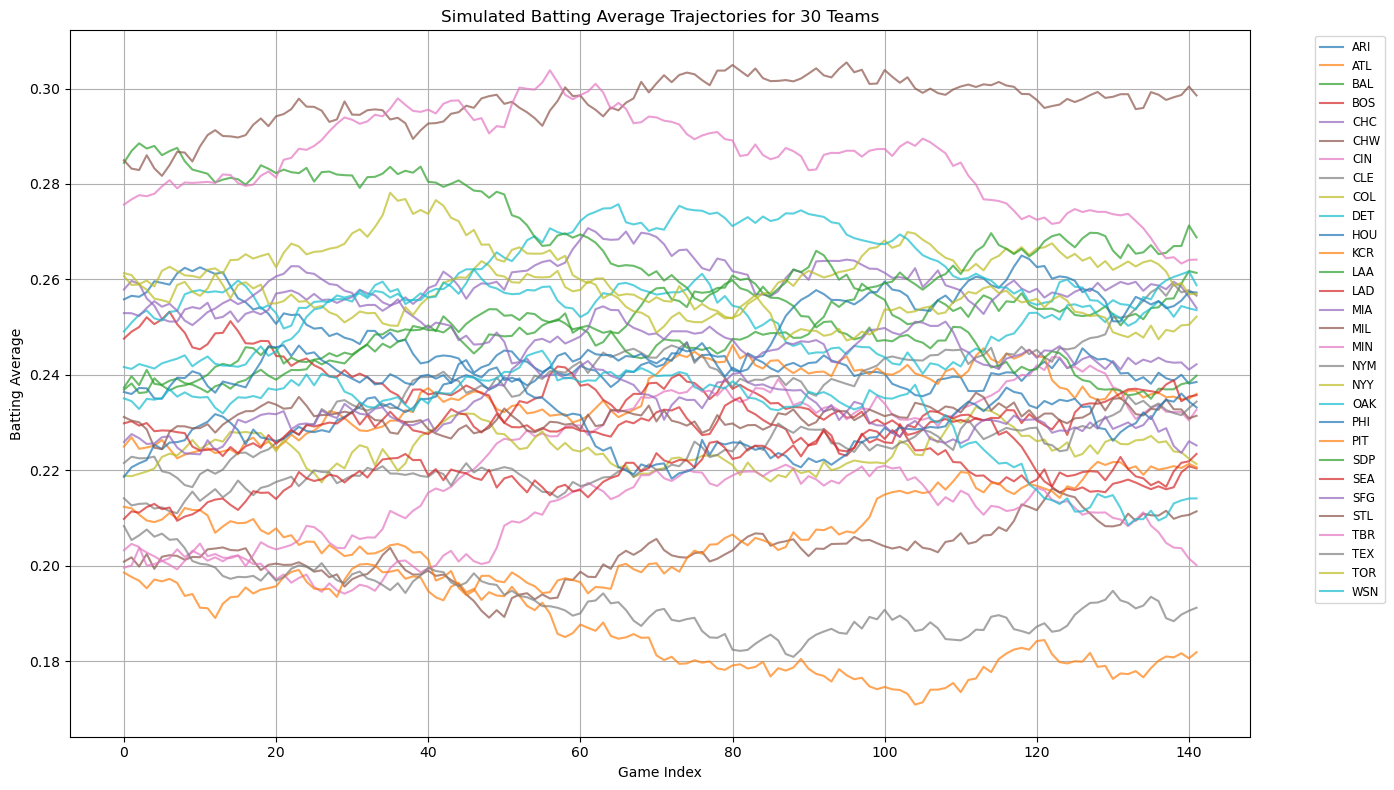

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
n_games = 142
std_dev = 0.0015  # Fixed standard deviation for batting avg random walk
np.random.seed(42)

# --- Simulate and Plot Batting Trajectories ---
plt.figure(figsize=(14, 8))

for _, row in batting_df.iterrows():
    team = row['Team Abbreviation']
    start_val = row['20th Batting Average']

    # Generate random walk
    walk = [start_val]
    for _ in range(1, n_games):
        walk.append(walk[-1] + np.random.normal(0, std_dev))

    plt.plot(walk, label=team, alpha=0.7)

plt.title("Simulated Batting Average Trajectories for 30 Teams")
plt.xlabel("Game Index")
plt.ylabel("Batting Average")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [121]:
import os
import pandas as pd

# Folder containing daily odds data
folder = "test_data/daily_odds"

# Collect all CSV files and sort by date
csv_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".csv")],
    key=lambda x: pd.to_datetime(x.replace(".csv", ""))
)

# Step 1: Get all unique teams across all CSVs
all_teams = set()
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    all_teams.update(df['homeTeam'].dropna().unique())
    all_teams.update(df['awayTeam'].dropna().unique())

# Step 2: Initialize tracking dict
team_appearances = {team: [] for team in all_teams}

# Step 3: Loop through files to collect first 10 games per team
for file in csv_files:
    df = pd.read_csv(os.path.join(folder, file))
    df['startDate'] = pd.to_datetime(df['startDate'])

    for _, row in df.iterrows():
        home_team, away_team = row['homeTeam'], row['awayTeam']
        home_pitcher, away_pitcher = row['homePitcher'], row['awayPitcher']
        game_date = row['startDate']

        if len(team_appearances[home_team]) < 20:
            team_appearances[home_team].append({
                'team': home_team,
                'date': game_date,
                'pitcher': home_pitcher,
                'home_or_away': 'home'
            })
        if len(team_appearances[away_team]) < 20:
            team_appearances[away_team].append({
                'team': away_team,
                'date': game_date,
                'pitcher': away_pitcher,
                'home_or_away': 'away'
            })

# Step 4: Flatten and convert to DataFrame
flattened = [entry for appearances in team_appearances.values() for entry in appearances]
result_df = pd.DataFrame(flattened)
result_df = result_df.sort_values(by=["team", "date"]).reset_index(drop=True)

# View or save
print(result_df)
# result_df.to_csv("first_10_pitchers_by_team.csv", index=False)


           team                      date          pitcher home_or_away
0       Arizona 2025-03-28 02:10:00+00:00       Zac Gallen         home
1       Arizona 2025-03-29 01:40:00+00:00    Merrill Kelly         home
2       Arizona 2025-03-30 00:10:00+00:00   Brandon Pfaadt         home
3       Arizona 2025-04-01 23:05:00+00:00    Corbin Burnes         away
4       Arizona 2025-04-02 23:05:00+00:00       Zac Gallen         away
..          ...                       ...              ...          ...
595  Washington 2025-04-15 22:40:00+00:00       Jake Irvin         away
596  Washington 2025-04-16 22:40:00+00:00  Mitchell Parker         away
597  Washington 2025-04-17 16:35:00+00:00  Trevor Williams         away
598  Washington 2025-04-19 20:10:00+00:00   MacKenzie Gore         away
599  Washington 2025-04-20 19:10:00+00:00       Jake Irvin         away

[600 rows x 4 columns]


In [122]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

# ------------- Setup -------------
pitcher_html_folder = "test_data/raw_pitcher_data"
output_rows = []

# Assume you already have a DataFrame `result_df`
result_df['date'] = pd.to_datetime(result_df['date']).dt.tz_localize(None).dt.normalize()
result_df['pitcher'] = result_df['pitcher'].str.strip().str.title()

# List of pitcher names to match
pitcher_names = result_df['pitcher'].unique()

# ----------- ERA Parser -----------
def parse_pitcher_era(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    rows = soup.find_all("tr", attrs={"data-index": True})
    data = []
    for row in rows:
        date_tag = row.find("td", {"data-col": "0"})
        era_tag = row.find("td", {"data-col": "5"})
        if not date_tag or not era_tag:
            continue

        date_str = date_tag.get_text(strip=True)
        try:
            full_date = pd.to_datetime(f"2025 {date_str}").tz_localize(None).normalize()
            era_val = era_tag.get_text(strip=True)
            era_val = float(era_val) if era_val.replace('.', '', 1).isdigit() else None
            if era_val is not None:
                data.append((full_date, era_val))
        except Exception:
            continue

    return pd.Series({d: e for d, e in sorted(data)})

# ----------- Match and Append ----------
for pitcher in tqdm(pitcher_names, desc="Matching ERAs"):
    filename = f"{pitcher.lower().replace(' ', '-')}_2025.html"
    filepath = os.path.join(pitcher_html_folder, filename)

    if not os.path.exists(filepath):
        continue

    era_series = parse_pitcher_era(filepath)
    era_series.index = pd.to_datetime(era_series.index).tz_localize(None).sort_values()

    df_subset = result_df[result_df['pitcher'] == pitcher].copy()

    def get_closest_prior_era(game_date):
        game_date = pd.to_datetime(game_date).tz_localize(None).normalize()
        eligible = era_series.index[era_series.index <= game_date]
        return era_series.loc[eligible[-1]] if not eligible.empty else None

    df_subset['matched_ERA'] = df_subset['date'].apply(get_closest_prior_era)
    output_rows.append(df_subset)

# ------------- Output -------------
final_df = pd.concat(output_rows, ignore_index=True)
print("✅ Saved combined results to matched_pitcher_eras.csv")
final_df

Matching ERAs: 100%|██████████| 177/177 [00:15<00:00, 11.32it/s]


✅ Saved combined results to matched_pitcher_eras.csv


/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/4102059469.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(output_rows, ignore_index=True)


,team,date,pitcher,home_or_away,matched_ERA
0,Arizona,2025-03-28,Zac Gallen,home,9.00
1,Arizona,2025-04-02,Zac Gallen,away,3.38
2,Arizona,2025-04-08,Zac Gallen,home,5.28
3,Arizona,2025-04-13,Zac Gallen,home,4.64
4,Arizona,2025-04-19,Zac Gallen,away,5.60
...,...,...,...,...,...
595,Washington,2025-04-05,Mitchell Parker,home,0.73
596,Washington,2025-04-11,Mitchell Parker,away,1.96
597,Washington,2025-04-16,Mitchell Parker,away,1.85
598,Washington,2025-04-08,Brad Lord,home,1.80


In [235]:
team_to_acronym = {
    "Dodgers": "LAD",
    "Mets": "NYM",
    "Orioles": "BAL",
    "Twins": "MIN",
    "Cubs": "CHC",
    "Tigers": "DET",
    "Athletics": "ATH",
    "Pirates": "PIT",
    "Phillies": "PHI",
    "Braves": "ATL",
    "Red Sox": "BOS",
    "Giants": "SFG",
    "Guardians": "CLE",
    "Angels": "LAA",
    "Brewers": "MIL",
    "Rockies": "COL",
    "Nationals": "WSN",
    "Royals": "KCR",
    "Rangers": "TEX",
    "D-backs": "ARI",
    "Reds": "CIN",
    "Astros": "HOU",
    "Marlins": "MIA",
    "Padres": "SDP",
    "Mariners": "SEA",
    "Blue Jays": "TOR",
    "Yankees": "NYY",
    "Rays": "TBR",
    "Cardinals": "STL",
    "White Sox": "CHW"
}

schedule = pd.read_csv("mlb_full_schedule.csv")
schedule['Home Team'] = schedule['Home Team'].map(team_to_acronym)
schedule['Away Team'] = schedule['Away Team'].map(team_to_acronym)
schedule

,Game Date,Day of Week,Local Time,Time - ET,Game,Away Team,Home Team,Location
0,3/18/25,Tuesday,6:00 AM,6:00 AM,Dodgers at Cubs,LAD,CHC,Tokyo Dome - Tokyo
1,3/19/25,Wednesday,6:00 AM,6:00 AM,Dodgers at Cubs,LAD,CHC,Tokyo Dome - Tokyo
2,3/27/25,Thursday,3:10 PM,4:10 PM,Mets at Astros,NYM,HOU,Daikin Park - Houston
3,3/27/25,Thursday,3:07 PM,3:07 PM,Orioles at Blue Jays,BAL,TOR,Rogers Centre - Toronto
4,3/27/25,Thursday,3:15 PM,4:15 PM,Twins at Cardinals,MIN,STL,Busch Stadium - St. Louis
...,...,...,...,...,...,...,...,...
2425,9/28/25,Sunday,3:05 PM,3:05 PM,White Sox at Nationals,CHW,WSN,Nationals Park - Washington
2426,9/28/25,Sunday,12:10 PM,3:10 PM,D-backs at Padres,ARI,SDP,Petco Park - San Diego
2427,9/28/25,Sunday,3:05 PM,3:05 PM,Twins at Phillies,MIN,PHI,Citizens Bank Park - Philadelphia
2428,9/28/25,Sunday,3:05 PM,3:05 PM,Tigers at Red Sox,DET,BOS,Fenway Park - Boston


In [ ]:
import pandas as pd

# Step 1: Convert date column and filter
schedule['Game Date'] = pd.to_datetime(schedule['Game Date'])
cutoff_date = pd.to_datetime("2025-04-20")

# Step 2: Separate games before April 20 to count games played
before_cutoff = schedule[schedule['Game Date'] < cutoff_date]
after_cutoff = schedule[schedule['Game Date'] >= cutoff_date]

# Step 3: Count games played before April 20 (as home or away)
home_games = before_cutoff['Home Team'].value_counts()
away_games = before_cutoff['Away Team'].value_counts()

# Total games played per team before April 20
games_played = home_games.add(away_games, fill_value=0).astype(int)

# Step 4: Total games each team will play is 162, so subtract to get games remaining
games_remaining = 162 - games_played

# Optional: Make into DataFrame for clarity
team_games_df = pd.DataFrame({
    'Games Played': games_played,
    'Games Remaining': games_remaining
}).sort_values('Games Remaining')

# Display
team_games_df['Total'] = team_games_df['Games Played'] + team_games_df['Games Remaining']

🎯 Games played and remaining for each team starting from April 20:


In [189]:
import numpy as np

# Setup
n_simulations = 1000
std_dev = 0.0015
np.random.seed(42)

# Ensure team abbreviation consistency
batting_df['Team Abbreviation'] = batting_df['Team Abbreviation'].replace('OAK', 'ATH')

# Get number of teams
n_teams = len(result_df)

# Create a dictionary to quickly map team abbreviations to games remaining
games_remaining_dict = team_games_df['Games Remaining'].to_dict()

# Initialize dynamic storage: a dictionary instead of fixed-size array
batting_simulation = {}

# Run simulations
for team_idx, (_, row) in enumerate(batting_df.iterrows()):
    team = row['Team Abbreviation']
    start_val = row['20th Batting Average']
    n_games = games_remaining_dict.get(team, 0)  # Get games remaining for this team

    # Preallocate shape (n_simulations, n_games)
    sims = np.zeros((n_simulations, n_games))

    for sim in range(n_simulations):
        walk = [start_val]
        for _ in range(1, n_games):
            walk.append(walk[-1] + np.random.normal(0, std_dev))
        sims[sim, :] = walk

    # Store
    batting_simulation[team] = sims


In [191]:
# Copy and clean ERA column
df = final_df.copy()
df['matched_ERA'] = pd.to_numeric(df['matched_ERA'], errors='coerce')

# Sort and compute average over whatever number of rows exist for each team
avg_era_per_team = (
    df.dropna(subset=['matched_ERA'])
      .sort_values(['team', 'date'])
      .groupby('team')
      .apply(lambda g: g['matched_ERA'].mean())  # just take mean of all rows per team
      .reset_index()
      .rename(columns={0: 'avg_era_first_N_games'})
)

print(avg_era_per_team)

              team  avg_era_first_N_games
0          Arizona               5.178000
1        Athletics               5.202857
2          Atlanta               4.290500
3        Baltimore               5.883500
4           Boston               4.936500
5        Chi. Cubs               4.333000
6   Chi. White Sox               3.414500
7       Cincinnati               2.986000
8        Cleveland               4.559375
9         Colorado               3.883000
10         Detroit               4.021000
11         Houston               3.682000
12     Kansas City               3.300500
13       LA Angels               4.241000
14      LA Dodgers               5.098500
15           Miami               5.284500
16       Milwaukee               4.948500
17       Minnesota               5.841000
18         NY Mets               2.585000
19      NY Yankees               5.183000
20    Philadelphia               2.899500
21      Pittsburgh               4.461000
22       San Diego               4

/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/3814868944.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['matched_ERA'].mean())  # just take mean of all rows per team


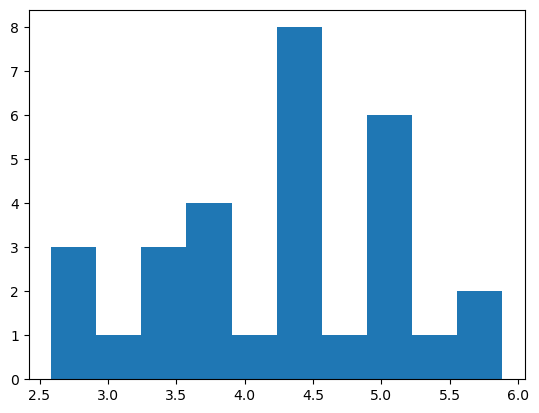

In [192]:
import matplotlib.pyplot as plt

plt.hist(avg_era_per_team['avg_era_first_N_games'])
plt.show()

/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/872973691.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values("startDate").head(20)['pitch_era'].mean())
Sliding windows per team: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]


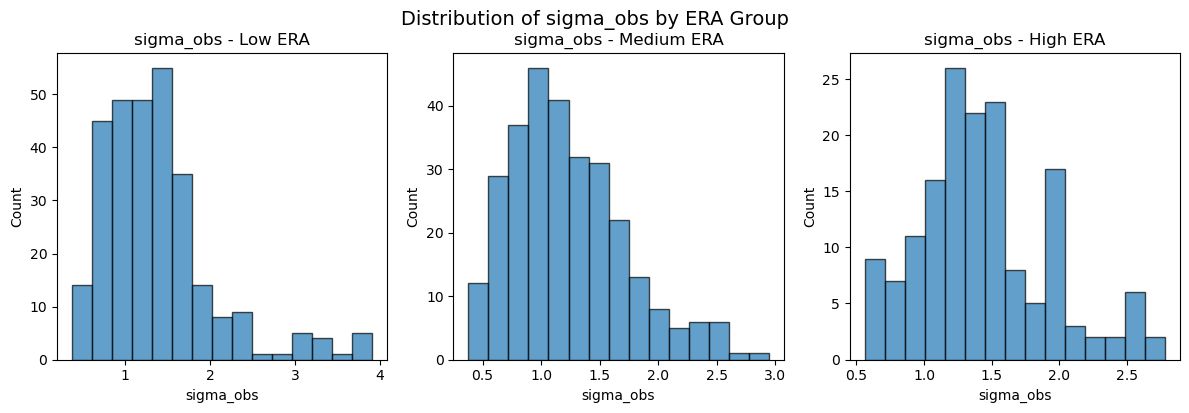

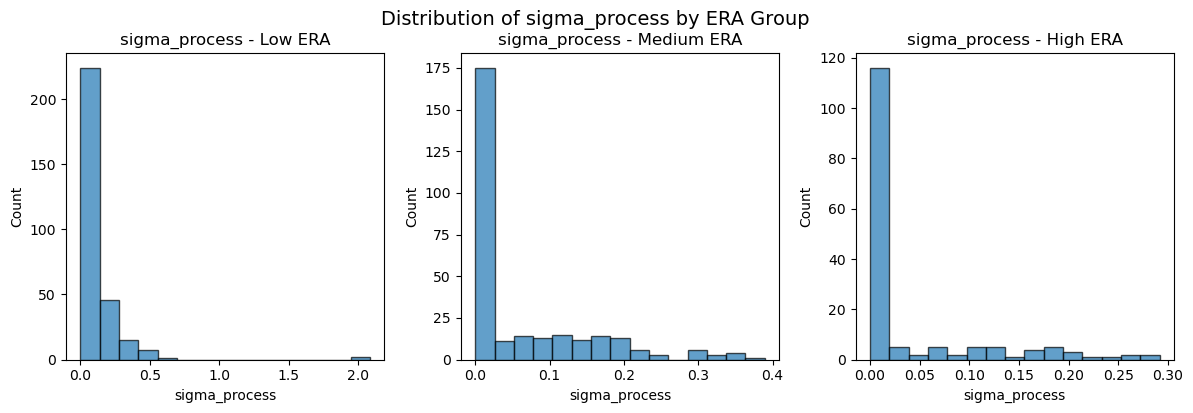

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from tqdm import tqdm

# Load and prep
data = pd.read_csv("master_df.csv")
data['startDate'] = pd.to_datetime(data['startDate'])
data['year'] = data['startDate'].dt.year

# Combine home/away ERA
home = data[['startDate', 'homeTeam', 'homePitcher_era']].rename(
    columns={'homeTeam': 'team', 'homePitcher_era': 'pitch_era'}
)
away = data[['startDate', 'awayTeam', 'awayPitcher_era']].rename(
    columns={'awayTeam': 'team', 'awayPitcher_era': 'pitch_era'}
)
long_df = pd.concat([home, away], ignore_index=True)
long_df = long_df.dropna(subset=['pitch_era'])
long_df = long_df.sort_values(['team', 'startDate'])

# Compute average ERA over first 20 appearances per team
first_20_era = (
    long_df.groupby("team")
    .apply(lambda x: x.sort_values("startDate").head(20)['pitch_era'].mean())
    .reset_index()
    .rename(columns={0: 'avg_era_20'})
)

# Bin teams into quantiles
first_20_era['group'] = pd.qcut(first_20_era['avg_era_20'], 3, labels=['low', 'medium', 'high'])

# Map group labels to long_df
long_df = long_df.merge(first_20_era[['team', 'group']], on='team', how='left')

# Sliding window settings
WINDOW_SIZE = 30
STEP = 5

# Results
results = []

# Loop through each team
for team, group_df in tqdm(long_df.groupby('team'), desc="Sliding windows per team"):
    group_df = group_df.sort_values('startDate').reset_index(drop=True)
    group_label = group_df['group'].iloc[0]

    if len(group_df) < WINDOW_SIZE or pd.isna(group_label):
        continue

    for start in range(0, len(group_df) - WINDOW_SIZE + 1, STEP):
        window = group_df.iloc[start:start + WINDOW_SIZE]

        try:
            model = UnobservedComponents(window['pitch_era'], level='local level')
            fit_result = model.fit(disp=False)
            sigma_obs = np.sqrt(fit_result.params.get('sigma2.irregular', np.nan))
            sigma_proc = np.sqrt(fit_result.params.get('sigma2.level', np.nan))
            results.append({
                'team': team,
                'group': group_label,
                'sigma_obs': sigma_obs,
                'sigma_process': sigma_proc
            })
        except Exception:
            continue

# Results to DataFrame
results_df = pd.DataFrame(results).dropna()

# Plot histograms for each group
for var in ['sigma_obs', 'sigma_process']:
    plt.figure(figsize=(12, 4))
    for i, grp in enumerate(['low', 'medium', 'high']):
        subset = results_df[results_df['group'] == grp]
        plt.subplot(1, 3, i + 1)
        plt.hist(subset[var], bins=15, edgecolor='black', alpha=0.7)
        plt.title(f'{var} - {grp.capitalize()} ERA')
        plt.xlabel(var)
        plt.ylabel("Count")
    plt.tight_layout()
    plt.suptitle(f"Distribution of {var} by ERA Group", y=1.02, fontsize=14)
    plt.show()


In [194]:
# Already computed avg_era_10 per team in earlier steps
# We now extract the boundaries from the qcut bin edges
bin_labels = ['low', 'medium', 'high']
bin_edges = pd.qcut(first_20_era['avg_era_20'], q=3, retbins=True, labels=bin_labels)[1]

# Print boundaries
for i in range(len(bin_edges) - 1):
    print(f"{bin_labels[i].capitalize()} ERA Group: {bin_edges[i]:.3f} to {bin_edges[i+1]:.3f}")

Low ERA Group: 2.687 to 3.591
Medium ERA Group: 3.591 to 4.219
High ERA Group: 4.219 to 5.605


In [195]:
team_name_to_acronym = {
    'Arizona': 'ARI',
    'Athletics': 'ATH',
    'Atlanta': 'ATL',
    'Baltimore': 'BAL',
    'Boston': 'BOS',
    'Chi. Cubs': 'CHC',
    'Chi. White Sox': 'CHW',
    'Cincinnati': 'CIN',
    'Cleveland': 'CLE',
    'Colorado': 'COL',
    'Detroit': 'DET',
    'Houston': 'HOU',
    'Kansas City': 'KCR',
    'LA Angels': 'LAA',
    'LA Dodgers': 'LAD',
    'Miami': 'MIA',
    'Milwaukee': 'MIL',
    'Minnesota': 'MIN',
    'NY Mets': 'NYM',
    'NY Yankees': 'NYY',
    'Philadelphia': 'PHI',
    'Pittsburgh': 'PIT',
    'San Diego': 'SDP',
    'San Francisco': 'SFG',
    'Seattle': 'SEA',
    'St. Louis': 'STL',
    'Tampa Bay': 'TBR',
    'Texas': 'TEX',
    'Toronto': 'TOR',
    'Washington': 'WSN'
}

# Define the bins and labels
bins = [0, 3.591, 4.219, 100]
labels = ['low', 'medium', 'high']

# Assign group labels based on avg_era
avg_era_per_team['group'] = pd.cut(
    avg_era_per_team['avg_era_first_N_games'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Display the result
avg_era_per_team['team'] = avg_era_per_team['team'].map(team_name_to_acronym)
print(avg_era_per_team)


   team  avg_era_first_N_games   group
0   ARI               5.178000    high
1   ATH               5.202857    high
2   ATL               4.290500    high
3   BAL               5.883500    high
4   BOS               4.936500    high
5   CHC               4.333000    high
6   CHW               3.414500     low
7   CIN               2.986000     low
8   CLE               4.559375    high
9   COL               3.883000  medium
10  DET               4.021000  medium
11  HOU               3.682000  medium
12  KCR               3.300500     low
13  LAA               4.241000    high
14  LAD               5.098500    high
15  MIA               5.284500    high
16  MIL               4.948500    high
17  MIN               5.841000    high
18  NYM               2.585000     low
19  NYY               5.183000    high
20  PHI               2.899500     low
21  PIT               4.461000    high
22  SDP               4.384000    high
23  SFG               4.504000    high
24  SEA               3.8

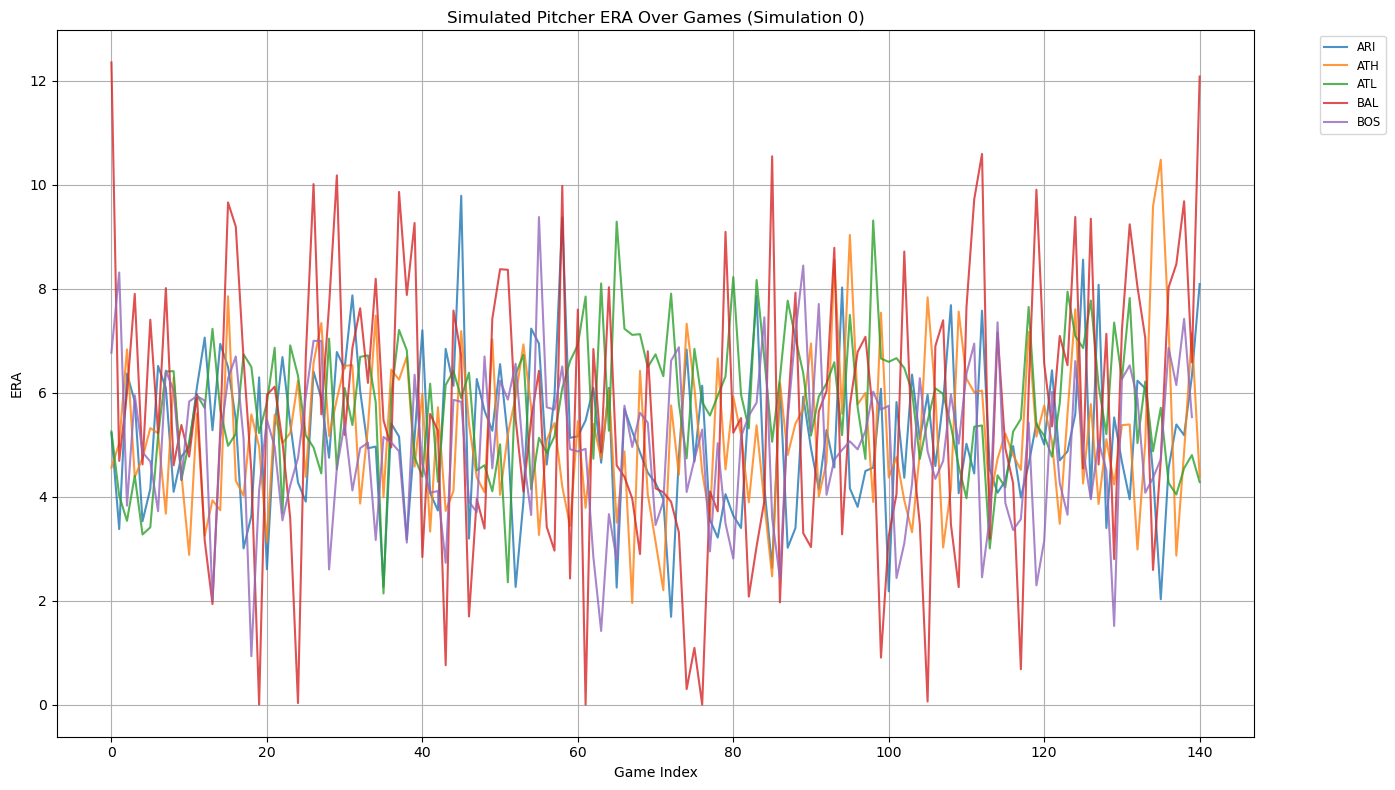

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs ---
n_simulations = 1000
np.random.seed(42)

# avg_era_per_team must have columns: 'team', 'group', 'era'
# team_games_df must have: index as team, column 'Games Remaining'
# results_df must have: columns 'group', 'sigma_obs', 'sigma_process'

era_simulations = {}

for _, row in avg_era_per_team.iterrows():
    team = row['team']
    group = row['group']
    start_era = row['avg_era_first_N_games']

    if pd.isna(group):
        continue

    group_data = results_df[results_df['group'] == group]

    try:
        n_games = team_games_df.loc[team, "Games Remaining"]
    except KeyError:
        continue

    if n_games <= 0 or group_data.empty:
        continue

    sims = np.zeros((n_simulations, n_games))

    for sim in range(n_simulations):
        sigma_obs = np.random.choice(group_data['sigma_obs'].values)
        sigma_proc = np.random.choice(group_data['sigma_process'].values)

        latent = [start_era]
        for _ in range(1, n_games):
            latent.append(latent[-1] + np.random.normal(0, sigma_proc))
        observed = np.array(latent) + np.random.normal(0, sigma_obs, size=n_games)
        observed = np.clip(observed, 0.0, 20.0)

        sims[sim, :] = observed

    era_simulations[team] = sims

# --- Plotting first sim for a few teams ---
teams_to_plot = list(era_simulations.keys())[:5]

plt.figure(figsize=(14, 8))
for team in teams_to_plot:
    sim = era_simulations[team][0]  # simulation 0
    plt.plot(range(len(sim)), sim, label=team, alpha=0.8)

plt.title("Simulated Pitcher ERA Over Games (Simulation 0)")
plt.xlabel("Game Index")
plt.ylabel("ERA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [259]:
import numpy as np

# Setup
n_simulations = 1000
np.random.seed(42)

# Initialize dictionary to store team-specific simulations
era_simulations = {}

# Run simulations per team
for _, row in avg_era_per_team.iterrows():
    team = row['team']
    group = row['group']
    start_era = row['avg_era_first_N_games']  # Use actual ERA

    if pd.isna(group):
        continue

    group_data = results_df[results_df['group'] == group]
    
    try:
        n_games = team_games_df.loc[team, "Games Remaining"]
    except KeyError:
        continue  # Skip if team not found

    if n_games <= 0 or group_data.empty:
        continue

    sims = np.zeros((n_simulations, n_games))

    for sim in range(n_simulations):
        sigma_obs = np.random.choice(group_data['sigma_obs'].values)
        sigma_proc = np.random.choice(group_data['sigma_process'].values)

        latent = [start_era]  # start at actual ERA
        for _ in range(1, n_games):
            latent.append(latent[-1] + np.random.normal(0, sigma_proc))
        observed = np.array(latent) + np.random.normal(0, sigma_obs, size=n_games)

        # Clip to realistic ERA range
        observed = np.clip(observed, 0.0, 20.0)

        sims[sim, :] = observed

    era_simulations[team] = sims


In [260]:
import os
import pandas as pd

folder = "test_data/season_win_percentage"

cutoff_date = pd.to_datetime("2025-04-20")

# List to collect results
win_percentages = []

# Loop through each file
for filename in os.listdir(folder):
    if filename.endswith(".csv") and filename.startswith("2025"):
        team_id = filename.split("_")[1].replace(".csv", "")
        if team_id == "OAK":
            team_id = "ATH"

        filepath = os.path.join(folder, filename)

        try:
            df = pd.read_csv(filepath)
            df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime
            df = df.sort_values("date").reset_index(drop=True)

            # Filter to games BEFORE April 20
            df_pre_cutoff = df[df['date'] < cutoff_date]

            if df_pre_cutoff.empty:
                continue

            last_game_row = df_pre_cutoff.iloc[-1]  # Most recent before 4/20

            win_percentages.append({
                "team": team_id,
                "last_game_date": last_game_row['date'],
                "games_played": len(df_pre_cutoff),
                "latest_win_percentage": last_game_row['win_percentage']
            })

        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

# Convert to DataFrame
win_df = pd.DataFrame(win_percentages)

# Show result
win_df


,team,last_game_date,games_played,latest_win_percentage
0,ATL,2025-04-19,20,0.350
1,DET,2025-04-19,21,0.619
2,SFG,2025-04-19,21,0.667
3,ATH,2025-04-19,21,0.476
4,BAL,2025-04-19,20,0.450
5,CHC,2025-04-19,23,0.609
6,BOS,2025-04-19,22,0.545
7,PHI,2025-04-19,21,0.619
8,CHW,2025-04-19,20,0.200
9,LAA,2025-04-19,20,0.500


Let's get simulations

In [261]:
for team in era_simulations:
    era_shape = era_simulations.get(team, np.array([])).shape
    batting_shape = batting_simulation.get(team, np.array([])).shape

    if era_shape != batting_shape:
        print(f"❌ Mismatch for {team}: ERA {era_shape}, Batting {batting_shape}")
    else:
        print(f"✅ {team}: shape {era_shape}")


✅ ARI: shape (1000, 141)
✅ ATH: shape (1000, 141)
✅ ATL: shape (1000, 141)
✅ BAL: shape (1000, 141)
✅ BOS: shape (1000, 140)
✅ CHC: shape (1000, 139)
✅ CHW: shape (1000, 142)
✅ CIN: shape (1000, 141)
✅ CLE: shape (1000, 142)
✅ COL: shape (1000, 142)
✅ DET: shape (1000, 141)
✅ HOU: shape (1000, 142)
✅ KCR: shape (1000, 140)
✅ LAA: shape (1000, 142)
✅ LAD: shape (1000, 140)
✅ MIA: shape (1000, 141)
✅ MIL: shape (1000, 141)
✅ MIN: shape (1000, 141)
✅ NYM: shape (1000, 141)
✅ NYY: shape (1000, 141)
✅ PHI: shape (1000, 141)
✅ PIT: shape (1000, 140)
✅ SDP: shape (1000, 141)
✅ SFG: shape (1000, 141)
✅ SEA: shape (1000, 141)
✅ STL: shape (1000, 141)
✅ TBR: shape (1000, 141)
✅ TEX: shape (1000, 141)
✅ TOR: shape (1000, 140)
✅ WSN: shape (1000, 141)


In [205]:
df = pd.read_csv('master_df.csv')

def american_to_implied_prob(odds):
    """Convert American odds to implied probability (with vig)."""
    return 100 / (odds + 100) if odds > 0 else -odds / (-odds + 100)

def add_fair_implied_probs(df):
    odds_columns = [
        'betmgm_opening_homeOdds', 'betmgm_opening_awayOdds',
        'fanduel_opening_homeOdds', 'fanduel_opening_awayOdds',
        'caesars_opening_homeOdds', 'caesars_opening_awayOdds',
        'bet365_opening_homeOdds', 'bet365_opening_awayOdds',
        'draftkings_opening_homeOdds', 'draftkings_opening_awayOdds'
    ]
    
    for i in range(0, len(odds_columns), 2):
        home_col = odds_columns[i]
        away_col = odds_columns[i+1]

        home_prob = df[home_col].apply(american_to_implied_prob)
        away_prob = df[away_col].apply(american_to_implied_prob)

        total_prob = home_prob + away_prob

        # Use .loc to avoid SettingWithCopyWarning
        df.loc[:, home_col.replace('Odds', 'FairProb')] = home_prob / total_prob
        df.loc[:, away_col.replace('Odds', 'FairProb')] = away_prob / total_prob

    return df

odds_df = add_fair_implied_probs(df)

def create_beta_prior(df):
    fair_prob_cols = [
        'betmgm_opening_homeFairProb',
        'fanduel_opening_homeFairProb',
        'caesars_opening_homeFairProb',
        'bet365_opening_homeFairProb',
        'draftkings_opening_homeFairProb'
    ]

    # Alpha: sum of home fair probs
    df['beta_alpha'] = df[fair_prob_cols].sum(axis=1)
    # Beta: sum of (1 - home fair probs)
    df['beta_beta'] = len(fair_prob_cols) - df['beta_alpha']

    # Optional: posterior mean for reference
    df['beta_mean'] = df['beta_alpha'] / (df['beta_alpha'] + df['beta_beta'])

    return df

beta_priors = create_beta_prior(odds_df)
beta_priors

,gameId,startDate,homeTeam,awayTeam,homePitcher,awayPitcher,homeScore,awayScore,betmgm_opening_homeOdds,betmgm_opening_awayOdds,...,fanduel_opening_awayFairProb,caesars_opening_homeFairProb,caesars_opening_awayFairProb,bet365_opening_homeFairProb,bet365_opening_awayFairProb,draftkings_opening_homeFairProb,draftkings_opening_awayFairProb,beta_alpha,beta_beta,beta_mean
0,259014,2022-05-21T00:10:00+00:00,Milwaukee,Washington,Eric Lauer,Erick Fedde,7,0,-190.0,155.0,...,0.369898,0.625202,0.374798,0.637105,0.362895,0.611511,0.388489,3.129484,1.870516,0.625897
1,259007,2022-05-21T00:10:00+00:00,Houston,Texas,Cristian Javier,Martin Perez,0,3,-185.0,150.0,...,0.369898,0.596849,0.403151,0.611511,0.388489,0.596273,0.403727,3.053464,1.946536,0.610693
2,259026,2022-05-21T17:05:00+00:00,NY Yankees,Chi. White Sox,Nestor Cortes,Dallas Keuchel,7,5,-225.0,180.0,...,0.338696,0.666598,0.333402,0.658120,0.341880,0.588212,0.411788,3.233919,1.766081,0.646784
3,259023,2022-05-21T19:07:00+00:00,Toronto,Cincinnati,Alek Manoah,Hunter Greene,3,1,-250.0,200.0,...,0.314607,0.693737,0.306263,0.694656,0.305344,0.658120,0.341880,3.413725,1.586275,0.682745
4,265633,2022-05-21T19:10:00+00:00,Colorado,NY Mets,German Marquez,Carlos Carrasco,1,5,-105.0,-115.0,...,0.515397,0.467532,0.532468,0.467532,0.532468,0.467532,0.532468,2.376366,2.623634,0.475273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,301021,2024-08-21T00:10:00+00:00,Kansas City,LA Angels,Cole Ragans,Tyler Anderson,5,9,-210.0,170.0,...,0.369898,0.634351,0.365649,0.630102,0.369898,0.644729,0.355271,3.185807,1.814193,0.637161
2347,301022,2024-08-21T00:10:00+00:00,Houston,Boston,Ronel Blanco,Nick Pivetta,5,6,-135.0,110.0,...,0.463039,0.542744,0.457256,0.542744,0.457256,0.542744,0.457256,2.711961,2.288039,0.542392
2348,301034,2024-08-21T01:40:00+00:00,San Diego,Minnesota,Martin Perez,Bailey Ober,7,5,100.0,-120.0,...,0.508909,0.478261,0.521739,0.478261,0.521739,0.473913,0.526087,2.399787,2.600213,0.479957
2349,301025,2024-08-21T01:45:00+00:00,San Francisco,Chi. White Sox,Robbie Ray,Davis Martin,4,1,-250.0,200.0,...,0.299838,0.671390,0.328610,0.669007,0.330993,0.675031,0.324969,3.397409,1.602591,0.679482


In [282]:
import pymc as pm
import numpy as np

# ------------------------------
# Data Prep (assuming this is already done)
# ------------------------------
alpha_data = np.clip(train_df['alpha'].values, 1e-6, None)
beta_data = np.clip(train_df['beta'].values, 1e-6, None)
gamma_data = np.clip(train_df['gamma'].values, 0.2, 5)
X_data = train_df['X'].astype(int).values

# ------------------------------
# Simplified Bayesian Model (No Sportsbook Prior)
# ------------------------------
with pm.Model() as model:
    r1 = pm.Uniform('r1', lower=-1, upper=4)
    r2 = pm.Uniform('r2', lower=-4, upper=4)
    r3 = pm.Uniform('r3', lower=-1, upper=4)
    delta = pm.Uniform('delta', lower=0, upper=4)

    log_m = pm.Normal("log_m", mu=2.5, sigma=1.0)
    m = pm.Deterministic("m", pm.math.minimum(pm.math.exp(log_m), 50.0))

    lambda_ = alpha_data ** r1 * beta_data ** r2 * gamma_data ** r3
    lambda_delta = lambda_ * delta

    a = m * lambda_delta
    b = m

    p_s = pm.Beta('p_s', alpha=a, beta=b, shape=len(X_data))
    X_obs = pm.Bernoulli('X_obs', p=p_s, observed=X_data)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.97,
        cores=4,
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r1, r2, r3, delta, log_m, p_s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [266]:
schedule['Game Date'] = pd.to_datetime(schedule['Game Date'])  # step 1: convert to datetime
filtered_schedule = schedule[schedule['Game Date'] >= pd.to_datetime("2025-04-20")]  # step 2: filter
filtered_schedule

,Game Date,Day of Week,Local Time,Time - ET,Game,Away Team,Home Team,Location
316,2025-04-20,Sunday,1:07 PM,4:07 PM,Giants at Angels,SFG,LAA,Angel Stadium - Anaheim
317,2025-04-20,Sunday,6:10 PM,7:10 PM,Padres at Astros,SDP,HOU,Daikin Park - Houston
318,2025-04-20,Sunday,1:37 PM,1:37 PM,Mariners at Blue Jays,SEA,TOR,Rogers Centre - Toronto
319,2025-04-20,Sunday,1:35 PM,1:35 PM,Twins at Braves,MIN,ATL,Truist Park - Atlanta
320,2025-04-20,Sunday,1:10 PM,2:10 PM,Athletics at Brewers,ATH,MIL,American Family Field - Milwaukee
...,...,...,...,...,...,...,...,...
2425,2025-09-28,Sunday,3:05 PM,3:05 PM,White Sox at Nationals,CHW,WSN,Nationals Park - Washington
2426,2025-09-28,Sunday,12:10 PM,3:10 PM,D-backs at Padres,ARI,SDP,Petco Park - San Diego
2427,2025-09-28,Sunday,3:05 PM,3:05 PM,Twins at Phillies,MIN,PHI,Citizens Bank Park - Philadelphia
2428,2025-09-28,Sunday,3:05 PM,3:05 PM,Tigers at Red Sox,DET,BOS,Fenway Park - Boston


In [277]:
# Copy schedule and fix team names
schedule_df = filtered_schedule[['Game Date', 'Away Team', "Home Team"]]
schedule_df['Away Team'] = schedule_df['Away Team'].replace({'OAK': 'ATH'})
schedule_df['Home Team'] = schedule_df['Home Team'].replace({'OAK': 'ATH'})

# Add simulation columns
schedule_df['Away_Batting_0'] = np.nan
schedule_df['Home_Batting_0'] = np.nan
schedule_df['Away_ERA_0'] = np.nan
schedule_df['Home_ERA_0'] = np.nan

# Initialize index trackers for each team
batting_index = {team: 0 for team in batting_simulation}
era_index = {team: 0 for team in era_simulations}

# Loop through schedule and assign values
for i, row in schedule_df.iterrows():
    for side in ['Away', 'Home']:
        team_col = f"{side} Team"
        team = row[team_col]

        # Batting
        if team in batting_simulation:
            idx = batting_index[team]
            sim_vals = batting_simulation[team][0]  # 0th simulation
            if idx < len(sim_vals):
                schedule_df.at[i, f"{side}_Batting_0"] = sim_vals[idx]
                batting_index[team] += 1

        # ERA
        if team in era_simulations:
            idx = era_index[team]
            sim_vals = era_simulations[team][0]  # 0th simulation
            if idx < len(sim_vals):
                schedule_df.at[i, f"{side}_ERA_0"] = sim_vals[idx]
                era_index[team] += 1


/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/686187233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule_df['Away Team'] = schedule_df['Away Team'].replace({'OAK': 'ATH'})
/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/686187233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule_df['Home Team'] = schedule_df['Home Team'].replace({'OAK': 'ATH'})
/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/686187233.py:7: SettingWithCopyWarning: 


In [278]:
# Step 1: Initialize columns
schedule_df['Away_WinPct_Initial'] = np.nan
schedule_df['Home_WinPct_Initial'] = np.nan

# Step 2: Track which teams have been assigned already
assigned_teams = {
    'Away': set(),
    'Home': set()
}

# Step 3: Convert win_df to dictionary for quick lookup
win_pct_lookup = dict(zip(win_df['team'], win_df['latest_win_percentage']))

# Step 4: Loop through schedule and attach the win percentage on first occurrence
for i, row in schedule_df.iterrows():
    for side in ['Away', 'Home']:
        team_col = f"{side} Team"
        pct_col = f"{side}_WinPct_Initial"
        team = row[team_col]

        if team not in assigned_teams[side] and team in win_pct_lookup:
            schedule_df.at[i, pct_col] = win_pct_lookup[team]
            assigned_teams[side].add(team)


In [280]:
print(schedule_df.columns.tolist())


['Game Date', 'Away Team', 'Home Team', 'Away_Batting_0', 'Home_Batting_0', 'Away_ERA_0', 'Home_ERA_0', 'Away_WinPct_Initial', 'Home_WinPct_Initial']


In [281]:
schedule_df["alpha"] = schedule_df["Home_WinPct_Initial"] / schedule_df["Away_WinPct_Initial"]
schedule_df["beta"] = schedule_df["Home_Batting_0"] / schedule_df["Away_Batting_0"]
schedule_df["gamma"] = schedule_df["Away_ERA_0"] / schedule_df["Home_ERA_0"]
schedule_df.replace([np.inf, -np.inf], np.nan, inplace=True)
schedule_df = schedule_df[['Game Date', 'Home Team', 'Away Team', 'alpha', 'beta', 'gamma', 'Home_WinPct_Initial', 'Away_WinPct_Initial']]
schedule_df

,Game Date,Home Team,Away Team,alpha,beta,gamma,Home_WinPct_Initial,Away_WinPct_Initial
316,2025-04-20,LAA,SFG,0.749625,1.048542,1.445667,0.500,0.667
317,2025-04-20,HOU,SDP,0.700280,0.768647,1.137291,0.500,0.714
318,2025-04-20,TOR,SEA,1.089695,1.245563,1.796723,0.571,0.524
319,2025-04-20,ATL,MIN,1.051051,1.106851,1.002860,0.350,0.333
320,2025-04-20,MIL,ATH,1.100840,0.956699,1.624116,0.524,0.476
...,...,...,...,...,...,...,...,...
2425,2025-09-28,WSN,CHW,NaN,1.245337,0.873017,NaN,NaN
2426,2025-09-28,SDP,ARI,NaN,1.184096,4.665456,NaN,NaN
2427,2025-09-28,PHI,MIN,NaN,1.211908,2.487932,NaN,NaN
2428,2025-09-28,BOS,DET,NaN,1.173061,0.550489,NaN,NaN


In [283]:
import numpy as np

def predict_win_probability_from_trace(trace, alpha, beta, gamma):
    """
    Predict posterior win probabilities using a trained PyMC trace 
    and new alpha, beta, gamma inputs.

    Parameters:
        trace: ArviZ InferenceData object (from pm.sample)
        alpha, beta, gamma: np.arrays of shape (n_games,)

    Returns:
        p_mean: Posterior mean win probabilities (n_games,)
        p_samples: Posterior samples (n_samples, n_games)
    """
    posterior = trace.posterior

    r1 = posterior['r1'].stack(sample=("chain", "draw")).values
    r2 = posterior['r2'].stack(sample=("chain", "draw")).values
    r3 = posterior['r3'].stack(sample=("chain", "draw")).values
    delta = posterior['delta'].stack(sample=("chain", "draw")).values
    m = posterior['m'].stack(sample=("chain", "draw")).values

    n_samples = len(r1)
    n_games = len(alpha)

    # Expand inputs across samples
    alpha_exp = np.tile(alpha, (n_samples, 1))
    beta_exp = np.tile(beta, (n_samples, 1))
    gamma_exp = np.tile(gamma, (n_samples, 1))

    # Forward pass
    lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
    lambda_delta = lambda_ * delta[:, None]

    a = m[:, None] * lambda_delta
    b = m[:, None]

    p_samples = np.random.beta(a, b)
    p_mean = p_samples.mean(axis=0)

    return p_mean, p_samples


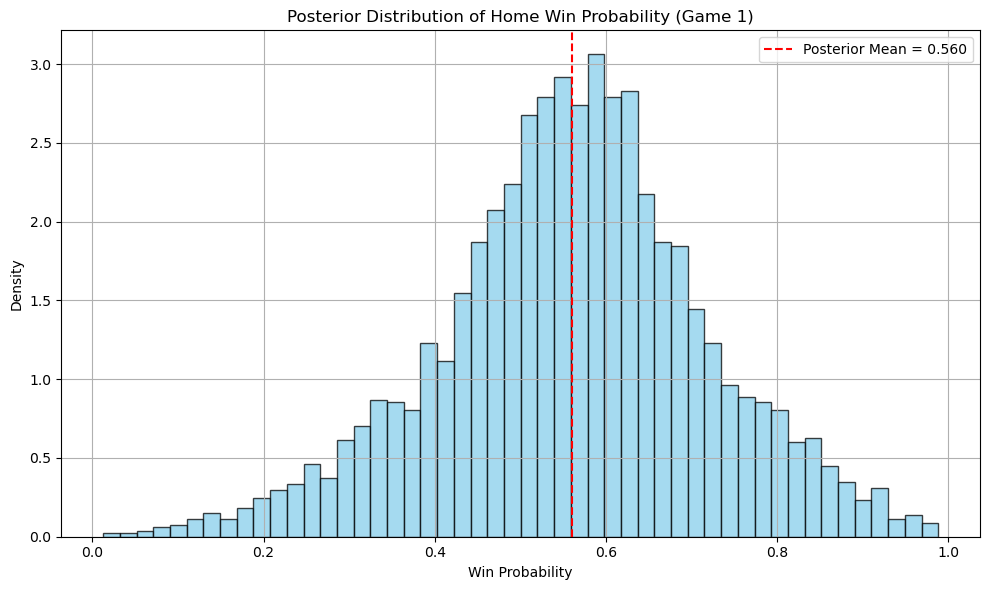

In [289]:
import matplotlib.pyplot as plt

# Extract alpha, beta, gamma for the first game
row = schedule_df.iloc[10]
alpha = np.clip(np.array([row['alpha']], dtype=float), 1e-6, None)
beta = np.clip(np.array([row['beta']], dtype=float), 1e-6, None)
gamma = np.clip(np.array([row['gamma']], dtype=float), 0.2, 5)

# Predict using PyMC trace
_, p_samples = predict_win_probability_from_trace(trace, alpha, beta, gamma)

# Plot the posterior distribution
plt.figure(figsize=(10, 6))
plt.hist(p_samples[:, 0], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='k')
plt.axvline(np.mean(p_samples[:, 0]), color='red', linestyle='--', label=f"Posterior Mean = {np.mean(p_samples[:, 0]):.3f}")
plt.title("Posterior Distribution of Home Win Probability (Game 1)")
plt.xlabel("Win Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [292]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli

# Ensure you already have: schedule_df, win_df, and trace defined

# ---------------------------------------
# Fix to prediction function to avoid invalid a, b
# ---------------------------------------
def predict_win_probability_from_trace(trace, alpha, beta, gamma):
    posterior = trace.posterior

    r1 = posterior['r1'].stack(sample=("chain", "draw")).values
    r2 = posterior['r2'].stack(sample=("chain", "draw")).values
    r3 = posterior['r3'].stack(sample=("chain", "draw")).values
    delta = posterior['delta'].stack(sample=("chain", "draw")).values
    m = posterior['m'].stack(sample=("chain", "draw")).values

    n_samples = len(r1)
    n_games = len(alpha)

    alpha_exp = np.tile(alpha, (n_samples, 1))
    beta_exp = np.tile(beta, (n_samples, 1))
    gamma_exp = np.tile(gamma, (n_samples, 1))

    lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
    lambda_delta = lambda_ * delta[:, None]

    a = np.clip(m[:, None] * lambda_delta, 1e-6, None)
    b = np.clip(m[:, None], 1e-6, None)

    p_samples = np.random.beta(a, b)
    p_mean = p_samples.mean(axis=0)

    return p_mean, p_samples

# ---------------------------------------
# Initialize team states from win_df
# ---------------------------------------
team_states = {}
for _, row in win_df.iterrows():
    team = row['team']
    games = row['games_played']
    win_pct = row['latest_win_percentage']
    wins = int(round(games * win_pct))
    team_states[team] = {'wins': wins, 'games': games}

# ---------------------------------------
# Create simulation dataframe
# ---------------------------------------
sim_schedule_df = schedule_df.copy()

sim_schedule_df['Sim_Home_WinProb'] = np.nan
sim_schedule_df['Sim_Home_Win'] = np.nan
sim_schedule_df['Updated_Home_WinPct'] = np.nan
sim_schedule_df['Updated_Away_WinPct'] = np.nan

# ---------------------------------------
# Simulate game-by-game
# ---------------------------------------
for idx, row in sim_schedule_df.iterrows():
    home = row['Home Team']
    away = row['Away Team']

    if home not in team_states or away not in team_states:
        continue

    # Current win states
    home_wins, home_games = team_states[home]['wins'], team_states[home]['games']
    away_wins, away_games = team_states[away]['wins'], team_states[away]['games']

    if home_games == 0 or away_games == 0:
        continue

    # Use current win% if original is NaN
    home_win_pct = home_wins / home_games
    away_win_pct = away_wins / away_games
    alpha = home_win_pct / away_win_pct

    if pd.isna(row['Home_WinPct_Initial']):
        sim_schedule_df.at[idx, 'Home_WinPct_Initial'] = home_win_pct
    if pd.isna(row['Away_WinPct_Initial']):
        sim_schedule_df.at[idx, 'Away_WinPct_Initial'] = away_win_pct
    sim_schedule_df.at[idx, 'alpha'] = alpha

    beta = row['beta']
    gamma = row['gamma']
    if np.isnan(alpha) or np.isnan(beta) or np.isnan(gamma):
        continue

    # Predict from posterior
    _, p_samples = predict_win_probability_from_trace(
        trace,
        np.array([alpha]),
        np.array([beta]),
        np.array([gamma])
    )

    sampled_p = np.random.choice(p_samples[:, 0])
    home_win = bernoulli.rvs(sampled_p)

    # Update team states
    team_states[home]['games'] += 1
    team_states[away]['games'] += 1
    if home_win == 1:
        team_states[home]['wins'] += 1
    else:
        team_states[away]['wins'] += 1

    # Log result
    sim_schedule_df.at[idx, 'Sim_Home_WinProb'] = sampled_p
    sim_schedule_df.at[idx, 'Sim_Home_Win'] = home_win
    sim_schedule_df.at[idx, 'Updated_Home_WinPct'] = team_states[home]['wins'] / team_states[home]['games']
    sim_schedule_df.at[idx, 'Updated_Away_WinPct'] = team_states[away]['wins'] / team_states[away]['games']


/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/1865627417.py:26: RuntimeWarning: divide by zero encountered in power
  lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])


In [294]:
# Create an empty dictionary to hold final win % for each team
final_win_pct = {}

# Get list of all unique teams that appeared in schedule
all_teams = pd.unique(sim_schedule_df[['Home Team', 'Away Team']].values.ravel())

# Loop through each team
for team in all_teams:
    # Find last row where team appears as home or away
    mask = (sim_schedule_df['Home Team'] == team) | (sim_schedule_df['Away Team'] == team)
    last_idx = sim_schedule_df[mask].index.max()

    if pd.isna(last_idx):
        continue  # skip teams that never played

    row = sim_schedule_df.loc[last_idx]

    # Prefer most recently updated win% from simulation
    if row['Home Team'] == team:
        win_pct = row['Updated_Home_WinPct']
    else:
        win_pct = row['Updated_Away_WinPct']

    if not pd.isna(win_pct):
        final_win_pct[team] = win_pct

# Convert to DataFrame
final_df = pd.DataFrame([
    {"team": team, "final_win_pct": pct, "projected_wins_162": round(pct * 162, 1)}
    for team, pct in final_win_pct.items()
])

# Sort by projected wins
final_df = final_df.sort_values(by="projected_wins_162", ascending=False).reset_index(drop=True)

# Show results
final_df


,team,final_win_pct,projected_wins_162
0,SFG,0.627329,101.6
1,BOS,0.606250,98.2
2,DET,0.591195,95.8
3,TEX,0.580247,94.0
4,TOR,0.577181,93.5
5,PHI,0.574074,93.0
6,CHC,0.571429,92.6
7,HOU,0.567901,92.0
8,LAD,0.555556,90.0
9,TBR,0.553459,89.7


In [297]:
np.sum(final_df['projected_wins_162'])

2431.6

In [302]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.stats import bernoulli

n_simulations = 200
dodgers_wins = []

# Precompute team list
team_list = pd.unique(schedule_df[['Home Team', 'Away Team']].values.ravel())

for sim in tqdm(range(n_simulations), desc="Simulating Seasons"):
    # Deep copy base schedule
    sim_schedule_df = schedule_df.copy()

    # Assign simulated batting and ERA stats for this simulation
    batting_index = {team: 0 for team in batting_simulation}
    era_index = {team: 0 for team in era_simulations}

    for i, row in sim_schedule_df.iterrows():
        for side in ['Away', 'Home']:
            team = row[f"{side} Team"]
            # Batting
            if team in batting_simulation:
                idx = batting_index[team]
                sim_vals = batting_simulation[team][sim]
                if idx < len(sim_vals):
                    sim_schedule_df.at[i, f"{side}_Batting_0"] = sim_vals[idx]
                    batting_index[team] += 1
            # ERA
            if team in era_simulations:
                idx = era_index[team]
                sim_vals = era_simulations[team][sim]
                if idx < len(sim_vals):
                    sim_schedule_df.at[i, f"{side}_ERA_0"] = sim_vals[idx]
                    era_index[team] += 1

    # Copy win_df to initialize team states
    team_states = {}
    for _, row in win_df.iterrows():
        team = row['team']
        games = row['games_played']
        win_pct = row['latest_win_percentage']
        wins = int(round(games * win_pct))
        team_states[team] = {'wins': wins, 'games': games}

    # Initialize winpct columns
    sim_schedule_df['Away_WinPct_Initial'] = np.nan
    sim_schedule_df['Home_WinPct_Initial'] = np.nan

    assigned_teams = {'Away': set(), 'Home': set()}
    win_pct_lookup = dict(zip(win_df['team'], win_df['latest_win_percentage']))

    for i, row in sim_schedule_df.iterrows():
        for side in ['Away', 'Home']:
            team = row[f"{side} Team"]
            col = f"{side}_WinPct_Initial"
            if team not in assigned_teams[side] and team in win_pct_lookup:
                sim_schedule_df.at[i, col] = win_pct_lookup[team]
                assigned_teams[side].add(team)

    # Compute alpha, beta, gamma
    sim_schedule_df["alpha"] = sim_schedule_df["Home_WinPct_Initial"] / sim_schedule_df["Away_WinPct_Initial"]
    sim_schedule_df["beta"] = sim_schedule_df["Home_Batting_0"] / sim_schedule_df["Away_Batting_0"]
    sim_schedule_df["gamma"] = sim_schedule_df["Away_ERA_0"] / sim_schedule_df["Home_ERA_0"]
    sim_schedule_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Prepare result columns
    sim_schedule_df['Sim_Home_Win'] = np.nan
    sim_schedule_df['Updated_Home_WinPct'] = np.nan
    sim_schedule_df['Updated_Away_WinPct'] = np.nan

    # Game-by-game simulation
    for idx, row in sim_schedule_df.iterrows():
        home = row['Home Team']
        away = row['Away Team']
        if home not in team_states or away not in team_states:
            continue

        home_wins, home_games = team_states[home]['wins'], team_states[home]['games']
        away_wins, away_games = team_states[away]['wins'], team_states[away]['games']
        if home_games == 0 or away_games == 0:
            continue

        home_win_pct = home_wins / home_games
        away_win_pct = away_wins / away_games
        alpha = home_win_pct / away_win_pct
        beta = row['beta']
        gamma = row['gamma']
        if np.isnan(alpha) or np.isnan(beta) or np.isnan(gamma):
            continue

        # Predict from trace
        _, p_samples = predict_win_probability_from_trace(
            trace,
            np.array([alpha]),
            np.array([beta]),
            np.array([gamma])
        )
        p = np.random.choice(p_samples[:, 0])
        p = np.clip(p, 0.0, 1.0)
        home_win = bernoulli.rvs(p)

        # Update states
        team_states[home]['games'] += 1
        team_states[away]['games'] += 1
        if home_win == 1:
            team_states[home]['wins'] += 1
        else:
            team_states[away]['wins'] += 1

    # Record final LAD win total
    if 'LAD' in team_states:
        final_wins = team_states['LAD']['wins']
        final_games = team_states['LAD']['games']
        win_pct = final_wins / final_games if final_games > 0 else 0
        dodgers_wins.append(round(win_pct * 162, 1))


Simulating Seasons:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/1865627417.py:26: RuntimeWarning: divide by zero encountered in power
  lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
Simulating Seasons:   0%|          | 1/200 [00:03<11:12,  3.38s/it]/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/1865627417.py:26: RuntimeWarning: divide by zero encountered in power
  lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
Simulating Seasons:   1%|          | 2/200 [00:06<11:15,  3.41s/it]/var/folders/hn/7wzd6_fs6wncrcy89b9jdj100000gn/T/ipykernel_83382/1865627417.py:26: RuntimeWarning: divide by zero encountered in power
  lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
Simulating Seasons:   1%|          | 2/200 [00:08<14:30,  4.40s/it]


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.bernoulli` documentation for details.

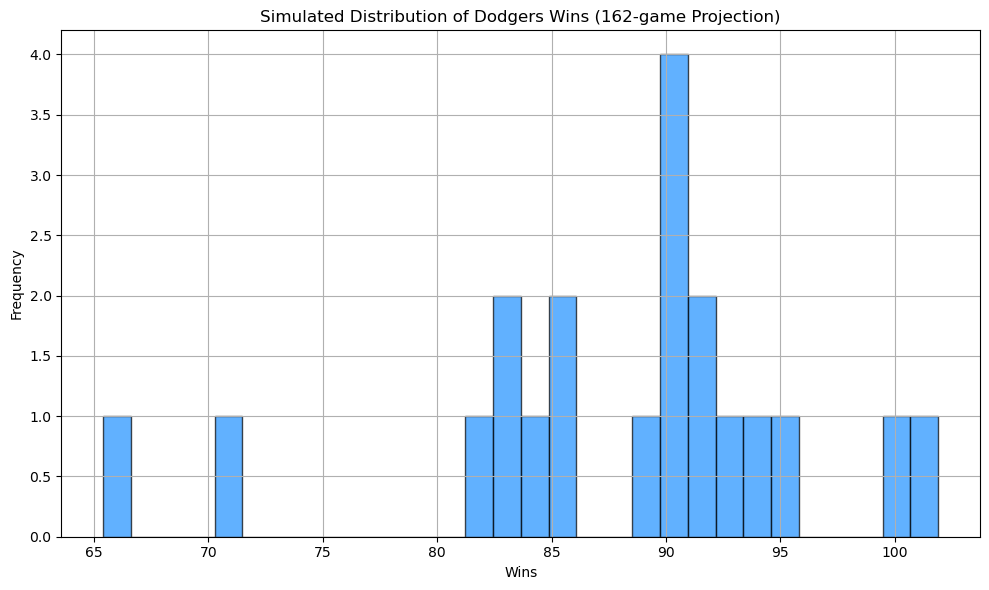

Mean Wins: 87.78
95% CI: [ 68.25   100.9975]


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dodgers_wins, bins=30, color='dodgerblue', edgecolor='black', alpha=0.7)
plt.title("Simulated Distribution of Dodgers Wins (162-game Projection)")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional summary
print(f"Mean Wins: {np.mean(dodgers_wins):.2f}")
print(f"95% CI: {np.percentile(dodgers_wins, [2.5, 97.5])}")
